# Classification - Loans dataset

In this notebook I will apply different classification algorithms to a loans dataset, and find the best one by computing the $F_1$ score.

(This dataset is taken from the *Machine Learning with Python* course by IBM on Coursera.)

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import NullFormatter
import pandas as pd
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv "https://drive.google.com/uc?export=download&id=1atJUAQY3Ob9_l0pwo3wWW8xvFELiImQJ"

--2020-10-05 20:18:12--  https://drive.google.com/uc?export=download&id=1atJUAQY3Ob9_l0pwo3wWW8xvFELiImQJ
Resolving drive.google.com (drive.google.com)... 172.217.19.206, 2a00:1450:400e:80c::200e
Connecting to drive.google.com (drive.google.com)|172.217.19.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-5o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ja63g75b2cd3pt2bfeg3govmbk6803uu/1601921850000/16348994772222974718/*/1atJUAQY3Ob9_l0pwo3wWW8xvFELiImQJ?e=download [following]
--2020-10-05 20:18:13--  https://doc-0o-5o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ja63g75b2cd3pt2bfeg3govmbk6803uu/1601921850000/16348994772222974718/*/1atJUAQY3Ob9_l0pwo3wWW8xvFELiImQJ?e=download
Resolving doc-0o-5o-docs.googleusercontent.com (doc-0o-5o-docs.googleusercontent.com)... 172.217.168.225, 2a00:1450:400e:80c::2001
Connecting to doc-0o-5o-docs.googleusercontent.com (doc-0o-5o-docs

### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection.


Lets plot some columns to underestand data better:

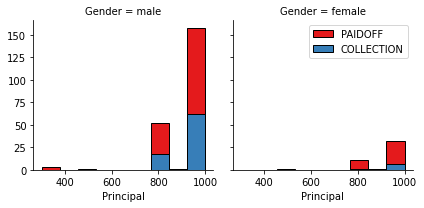

In [7]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

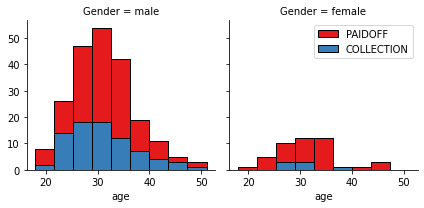

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

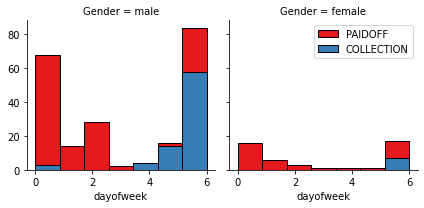

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 8)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week don't pay it off, so let's use *feature binarization* to set a threshold value less then day 4.

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


### Lets look at the month in which people should pay the loan 

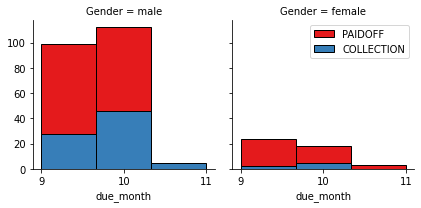

In [11]:
df['due_month'] = df['due_date'].dt.month
bins = np.linspace(df.due_month.min(), df.due_month.max(), 4)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'due_month', bins=bins, ec="k")
plt.xticks(range(df.due_month.min(), df.due_month.max()+1))
g.axes[-1].legend()
plt.show()

## Convert Categorical features to numerical values

Lets look at the Gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of females pay their loans while only 73 % of males pay their loan.


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

### Adding a column that counts how many days before the due_date the payment was executed

In order to keep the information contained in the colum due_date with respect to the column effective_date, we create a new column early_payment which contains the difference in days between due_date and effective_date.

In [14]:
df['early_payment'] = (df['due_date']-df['effective_date']).dt.days
df.early_payment.value_counts()

29    176
14    139
59     12
6      11
44      5
13      3
Name: early_payment, dtype: int64

## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [16]:
df['education'].value_counts()

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

Since we only have 44 'Bechalor' and 2 'Masters and above', we merge these two classes in a new class 'University degree'

In [17]:
df.education = df.education.replace({'Bechalor': 'University degree', 'Master or Above': 'University degree'})

### We use the one hot encoding technique to convert the categorical variable *'education'* to binary variables and append them to the feature Data Frame 

In [18]:
Feature = df[['Principal','terms','age','Gender','weekend','early_payment']]
Feature = pd.concat([Feature, pd.get_dummies(df['education'])], axis=1)
Feature.head()

,Principal,terms,age,Gender,weekend,early_payment,High School or Below,University degree,college
0,1000,30,45,0,0,29,1,0,0
1,1000,30,33,1,0,29,0,1,0
2,1000,15,27,0,0,14,0,0,1
3,1000,30,28,1,1,29,0,0,1
4,1000,30,29,0,1,29,0,0,1


Notice that we do not consider as feature the columns 'effective_date', 'due_date', 'dayofweek' and 'due_month', because we already used the information contained in those columns in the new columns 'weekend' and 'early_payment'.

### Feature selection

We define the feature set $X$ containing the features we selected before:

In [19]:
X = Feature
print(X.shape)
X.head()

(346, 9)


,Principal,terms,age,Gender,weekend,early_payment,High School or Below,University degree,college
0,1000,30,45,0,0,29,1,0,0
1,1000,30,33,1,0,29,0,1,0
2,1000,15,27,0,0,14,0,0,1
3,1000,30,28,1,1,29,0,0,1
4,1000,30,29,0,1,29,0,0,1


We define the target variable $y$ which is the loan_status column.

In [20]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Training and validation sets

We split the datasets $X$ and $y$ into training and validation sets.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Validation set:', X_val.shape,  y_val.shape)

Train set: (276, 9) (276,)
Validation set: (70, 9) (70,)


## Normalize Data 

After splitting the data, we use normalize the data giving it zero mean and unit variance.

In [22]:
scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scale.transform(X_train)
X_val_scaled = scale.transform(X_val)
X_train_scaled[0:5]

array([[ 0.56081126, -0.9677917 ,  0.69858179, -0.40565621, -1.17444044,
        -0.87391174, -0.90321065, -0.41169348,  1.21007674],
       [ 0.56081126,  0.9437816 , -0.81959596, -0.40565621,  0.85146932,
         0.5393674 ,  1.10716144, -0.41169348, -0.82639387],
       [ 0.56081126,  0.9437816 ,  0.02383612, -0.40565621, -1.17444044,
         0.5393674 , -0.90321065, -0.41169348,  1.21007674],
       [ 0.56081126, -0.9677917 , -0.98828237, -0.40565621,  0.85146932,
        -0.87391174, -0.90321065, -0.41169348,  1.21007674],
       [ 0.56081126,  0.9437816 , -0.48222312, -0.40565621, -1.17444044,
         0.5393674 , -0.90321065, -0.41169348,  1.21007674]])

# Classification 

Now we use the training set to build an accurate model and then use the validation set to report the accuracy of the model.

We are going to use the following four algorithms:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

In [23]:
from sklearn import metrics

# K Nearest Neighbor(KNN)

In [24]:
from sklearn.neighbors import KNeighborsClassifier

We look for the best value of $k$ to build the model with the best accuracy.  

In [25]:
KNN_acc_val = []
h = 16
for k in range(1, h):
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train_scaled, y_train)
    y_KNN = neigh.predict(X_val_scaled)
    pred_accuracy = metrics.accuracy_score(y_val, y_KNN)
    KNN_acc_val.append(pred_accuracy)
    print(f'n_neighbors: {k}\tAccuracy: {pred_accuracy}')

n_neighbors: 1	Accuracy: 0.7142857142857143
n_neighbors: 2	Accuracy: 0.6571428571428571
n_neighbors: 3	Accuracy: 0.7857142857142857
n_neighbors: 4	Accuracy: 0.7285714285714285
n_neighbors: 5	Accuracy: 0.7428571428571429
n_neighbors: 6	Accuracy: 0.7142857142857143
n_neighbors: 7	Accuracy: 0.7714285714285715
n_neighbors: 8	Accuracy: 0.7857142857142857
n_neighbors: 9	Accuracy: 0.7714285714285715
n_neighbors: 10	Accuracy: 0.6857142857142857
n_neighbors: 11	Accuracy: 0.7428571428571429
n_neighbors: 12	Accuracy: 0.7
n_neighbors: 13	Accuracy: 0.6714285714285714
n_neighbors: 14	Accuracy: 0.6571428571428571
n_neighbors: 15	Accuracy: 0.7142857142857143


### Plot accuracy score for different values of k

Best value of k: 3
Best value of accuracy score for validation set: 0.7857142857142857


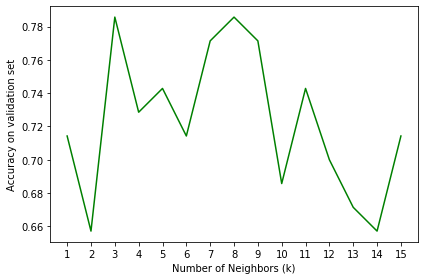

In [26]:
best_k = np.argmax(KNN_acc_val) + 1
print('Best value of k:', best_k)
print('Best value of accuracy score for validation set:', max(KNN_acc_val))
plt.plot(range(1,h), KNN_acc_val,'g')
plt.xticks(np.arange(1, h))
plt.ylabel('Accuracy on validation set')
plt.xlabel('Number of Neighbors (k)')
plt.tight_layout()
plt.show()

# Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
DT_acc_val = []
h = 16
for k in range(3,h):
    decTree = DecisionTreeClassifier(criterion="entropy", max_depth = k).fit(X_train, y_train)
    y_DT = decTree.predict(X_val)
    pred_accuracy = metrics.accuracy_score(y_val, y_DT)
    DT_acc_val.append(pred_accuracy)
    print(f'Max_depth: {k}\tAccuracy: {pred_accuracy}')    

Max_depth: 3	Accuracy: 0.6142857142857143
Max_depth: 4	Accuracy: 0.6142857142857143
Max_depth: 5	Accuracy: 0.7857142857142857
Max_depth: 6	Accuracy: 0.7857142857142857
Max_depth: 7	Accuracy: 0.6571428571428571
Max_depth: 8	Accuracy: 0.7142857142857143
Max_depth: 9	Accuracy: 0.7285714285714285
Max_depth: 10	Accuracy: 0.6857142857142857
Max_depth: 11	Accuracy: 0.7
Max_depth: 12	Accuracy: 0.7
Max_depth: 13	Accuracy: 0.6714285714285714
Max_depth: 14	Accuracy: 0.7
Max_depth: 15	Accuracy: 0.6857142857142857


### Plot accuracy score for different values of depths

Best value of depth: 5
Best value of accuracy score for validation set: 0.7857142857142857


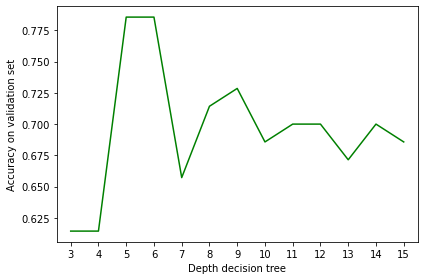

In [29]:
best_depth = np.argmax(DT_acc_val)+3
print('Best value of depth:', best_depth)
print('Best value of accuracy score for validation set:', max(DT_acc_val))
plt.plot(range(3,h), DT_acc_val,'g')
plt.xticks(np.arange(1, h))
plt.xlim(2.5, 15.5)
plt.ylabel('Accuracy on validation set')
plt.xlabel('Depth decision tree')
plt.tight_layout()
plt.show()

### Feature importance

In [30]:
decTree.feature_importances_

array([0.04705978, 0.0660233 , 0.33310669, 0.08888965, 0.30656424,
       0.05992151, 0.02146069, 0.04325514, 0.033719  ])

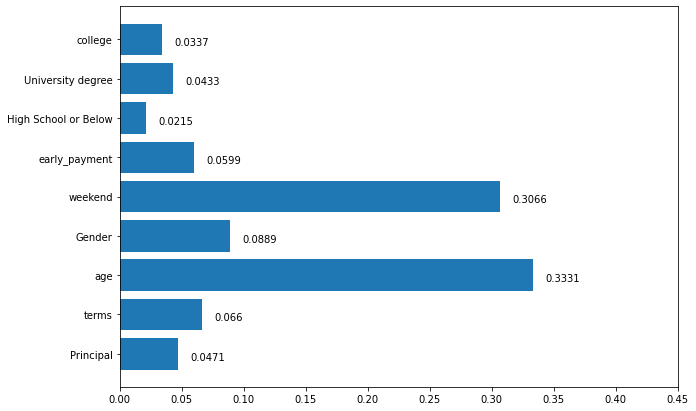

In [31]:
fig, ax = plt.subplots(figsize=(10,7))
ax.barh(Feature.columns, decTree.feature_importances_)
plt.xlim(0, 0.45)
for i, v in enumerate(decTree.feature_importances_):
    ax.text(v+0.01, i-0.15, str(round(v,4)), color='black')

# Support Vector Machine

In [32]:
from sklearn import svm

In [33]:
SVM_acc_val = []
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
for k in kernel:
    SVM = svm.SVC(kernel=k).fit(X_train_scaled, y_train) 
    y_SVM = SVM.predict(X_val_scaled)    
    pred_accuracy = metrics.accuracy_score(y_val, y_SVM)
    SVM_acc_val.append(pred_accuracy)
    print(f'Kernel: {k}\tAccuracy: {pred_accuracy}')   

Kernel: linear	Accuracy: 0.7714285714285715
Kernel: poly	Accuracy: 0.7857142857142857
Kernel: rbf	Accuracy: 0.7428571428571429
Kernel: sigmoid	Accuracy: 0.7428571428571429


### Plot accuracy score for different kernels

Best kernel: poly
Best value of accuracy score for validation set: 0.7857142857142857


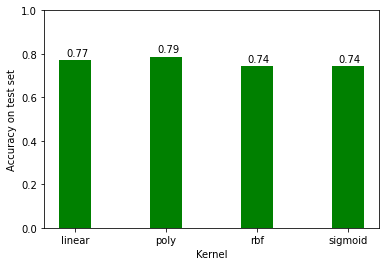

In [34]:
best_kernel = kernel[np.argmax(SVM_acc_val)]
print('Best kernel:', best_kernel)
print('Best value of accuracy score for validation set:', max(SVM_acc_val))
h = len(kernel)+1
x = np.arange(len(kernel))  # the label locations
width = 0.35
plt.bar(x, SVM_acc_val, width, label='Accuracy validation set', color = 'g')
plt.xticks(np.arange(0, h-1), kernel)
plt.ylabel('Accuracy on test set')
plt.xlabel('Kernel')
plt.ylim(0, 1)
for i, v in enumerate(SVM_acc_val):
    plt.text(i-0.1, v+0.02, str(round(v,2)), color='black')

# Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
LR_acc_val = []
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
for k in solver:
    LR = LogisticRegression(C = 0.01, solver = k).fit(X_train_scaled, y_train) 
    y_LR = LR.predict(X_val_scaled)
    pred_accuracy = metrics.accuracy_score(y_val, y_LR)
    LR_acc_val.append(pred_accuracy)
    print(f'Solver: {k}     \tAccuracy: {pred_accuracy}')   

Solver: newton-cg     	Accuracy: 0.7857142857142857
Solver: lbfgs     	Accuracy: 0.7857142857142857
Solver: liblinear     	Accuracy: 0.6714285714285714
Solver: sag     	Accuracy: 0.7857142857142857
Solver: saga     	Accuracy: 0.7857142857142857


### Plot accuracy score for different solvers

Best solver: newton-cg
Best value of accuracy score for validation set: 0.7857142857142857


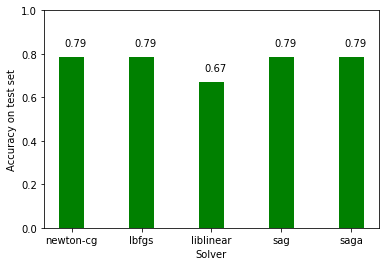

In [37]:
best_solver = solver[np.argmax(LR_acc_val)]
print('Best solver:', best_solver)
print('Best value of accuracy score for validation set:', max(LR_acc_val))
h = len(solver)+1
x = np.arange(len(solver))  # the label locations
plt.bar(x, LR_acc_val, width, label='Accuracy validation set', color = 'g')
plt.xticks(np.arange(0, h-1), solver)
plt.ylabel('Accuracy on test set')
plt.xlabel('Solver')
plt.ylim(0, 1)
for i, v in enumerate(LR_acc_val):
    plt.text(i-0.1, v + 0.05, str(round(v,2)), color='black')

# AdaBoost

In [38]:
from sklearn.ensemble import AdaBoostClassifier

In [39]:
AB_acc_val = []
for k in range(10,101,10):
    AdaBoost = AdaBoostClassifier(n_estimators=k, random_state=0).fit(X_train_scaled, y_train)
    y_AB = AdaBoost.predict(X_val_scaled)
    pred_accuracy = metrics.accuracy_score(y_val, y_AB)
    AB_acc_val.append(pred_accuracy)
    print(f'Parameter n_estimators: {k}\tAccuracy: {pred_accuracy}')

Parameter n_estimators: 10	Accuracy: 0.7714285714285715
Parameter n_estimators: 20	Accuracy: 0.7285714285714285
Parameter n_estimators: 30	Accuracy: 0.7285714285714285
Parameter n_estimators: 40	Accuracy: 0.7571428571428571
Parameter n_estimators: 50	Accuracy: 0.7571428571428571
Parameter n_estimators: 60	Accuracy: 0.7714285714285715
Parameter n_estimators: 70	Accuracy: 0.7714285714285715
Parameter n_estimators: 80	Accuracy: 0.7571428571428571
Parameter n_estimators: 90	Accuracy: 0.7142857142857143
Parameter n_estimators: 100	Accuracy: 0.7142857142857143


Best value of n_estimators: 10
Best value of accuracy score for validation set: 0.7714285714285715


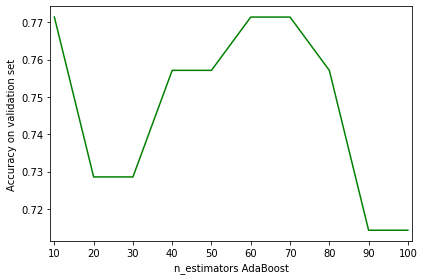

In [40]:
best_n = np.argmax(AB_acc_val)*10+10
print('Best value of n_estimators:', best_n)
print('Best value of accuracy score for validation set:', max(AB_acc_val))
plt.plot(range(10,101,10), AB_acc_val,'g')
plt.xticks(np.arange(10,101,10))
plt.xlim(9, 101)
plt.ylabel('Accuracy on validation set')
plt.xlabel('n_estimators AdaBoost')
plt.tight_layout()
plt.show()

## Accuracy of the models and best parameters

In [41]:
scores_val = {'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression', 'AdaBoost'],
              'Accuracy': [max(KNN_acc_val), max(DT_acc_val), max(SVM_acc_val), max(LR_acc_val), max(AB_acc_val)], 
              'Parameter': ['n_neighbors', 'depth', 'kernel', 'solver', 'n_estimators'],
              'Best parameter': [best_k, best_depth, best_kernel, best_solver, best_n]}
df_scores_val = pd.DataFrame.from_dict(scores_val)
df_scores_val.set_index('Algorithm')

,Accuracy,Parameter,Best parameter
Algorithm,,,
KNN,0.785714,n_neighbors,3
Decision Tree,0.785714,depth,5
SVM,0.785714,kernel,poly
LogisticRegression,0.785714,solver,newton-cg
AdaBoost,0.771429,n_estimators,10


# Model Evaluation using Test set

In [42]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [43]:
!wget -O loan_test.csv "https://drive.google.com/uc?export=download&id=1RZZD3d-Oqi7gyriKpT6fXtFHoDEiOxGl"

--2020-10-05 20:18:34--  https://drive.google.com/uc?export=download&id=1RZZD3d-Oqi7gyriKpT6fXtFHoDEiOxGl
Resolving drive.google.com (drive.google.com)... 172.217.19.206, 2a00:1450:400e:80c::200e
Connecting to drive.google.com (drive.google.com)|172.217.19.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-5o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/djgdhkp0sit1pjdk0eppp5i5e9kjro8u/1601921850000/16348994772222974718/*/1RZZD3d-Oqi7gyriKpT6fXtFHoDEiOxGl?e=download [following]
--2020-10-05 20:18:34--  https://doc-08-5o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/djgdhkp0sit1pjdk0eppp5i5e9kjro8u/1601921850000/16348994772222974718/*/1RZZD3d-Oqi7gyriKpT6fXtFHoDEiOxGl?e=download
Resolving doc-08-5o-docs.googleusercontent.com (doc-08-5o-docs.googleusercontent.com)... 172.217.168.225, 2a00:1450:400e:80c::2001
Connecting to doc-08-5o-docs.googleusercontent.com (doc-08-5o-docs

### Load Test set for evaluation 

In [44]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [45]:
test_df.shape

(54, 10)

In [46]:
test_df.education = test_df.education.replace({'Bechalor': 'University degree', 
                                               'Master or Above': 'University degree'})

In [47]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['due_month'] = test_df['due_date'].dt.month
test_df['early_payment'] = (test_df['due_date']-test_df['effective_date']).dt.days
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

In [48]:
Feature2 = test_df[['Principal','terms','age','Gender','weekend','early_payment']]
Feature2 = pd.concat([Feature2, pd.get_dummies(test_df['education'])], axis=1)

In [49]:
print(Feature2.shape)
Feature2.head()

(54, 9)


,Principal,terms,age,Gender,weekend,early_payment,High School or Below,University degree,college
0,1000,30,50,1,0,29,0,1,0
1,300,7,35,0,1,6,0,1,0
2,1000,30,43,1,1,29,1,0,0
3,1000,30,26,0,1,29,0,0,1
4,800,15,29,0,1,14,0,1,0


In [51]:
X2_test = Feature2
scale2 = preprocessing.StandardScaler().fit(X)
X2_train_scaled = scale2.transform(X)
X2_test_scaled = scale2.transform(X2_test)
y2 = test_df['loan_status'].values

In [52]:
X2_train, X2_test, y2_train, y2_test = X, X2_test, y, y2 
print ('Train set:', X2_train.shape,  y2_train.shape)
print ('Test set:', X2_test.shape,  y2_test.shape)

Train set: (346, 9) (346,)
Test set: (54, 9) (54,)


### Scores for K-Nearest Neighbors

In [53]:
neigh2 = KNeighborsClassifier(n_neighbors = 7).fit(X2_train_scaled, y2_train)
y2_KNN = neigh2.predict(X2_test_scaled)
KNN_acc = metrics.accuracy_score(y2_test, y2_KNN)
KNN_jacc = metrics.jaccard_score(y2_test, y2_KNN, pos_label = "PAIDOFF")
KNN_f1 = f1_score(y2_test, y2_KNN, pos_label = "PAIDOFF")
print('Accuracy:', KNN_acc)
print('Jaccard similarity:', KNN_jacc)
print('F1 score:', KNN_f1)

Accuracy: 0.6481481481481481
Jaccard similarity: 0.6415094339622641
F1 score: 0.7816091954022989


### Scores for Decision Trees

In [54]:
decTree2 = DecisionTreeClassifier(criterion="entropy", max_depth = best_depth).fit(X2_train, y2_train)
y2_DT = decTree2.predict(X2_test)
DT_acc = metrics.accuracy_score(y2_test, y2_DT)
DT_jacc = metrics.jaccard_score(y2_test, y2_DT, pos_label = "PAIDOFF")
DT_f1 = f1_score(y2_test, y2_DT, pos_label = "PAIDOFF")
print('Accuracy:', DT_acc)
print('Jaccard similarity:', DT_jacc)
print('F1 score:', DT_f1)

Accuracy: 0.6851851851851852
Jaccard similarity: 0.6851851851851852
F1 score: 0.8131868131868133


### Scores for Support Vector Machine

In [55]:
SVM2 = svm.SVC(kernel = best_kernel).fit(X2_train_scaled, y2_train) 
y2_SVM = SVM2.predict(X2_test_scaled)
SVM_acc = metrics.accuracy_score(y2_test, y2_SVM)
SVM_jacc = metrics.jaccard_score(y2_test, y2_SVM, pos_label = "PAIDOFF")
SVM_f1 = f1_score(y2_test, y2_SVM, pos_label = "PAIDOFF")
print('Accuracy:', SVM_acc)
print('Jaccard similarity:', SVM_jacc)
print('F1 score:', SVM_f1)

Accuracy: 0.7037037037037037
Jaccard similarity: 0.6923076923076923
F1 score: 0.8181818181818182


### Scores for Logistic Regression

In [60]:
LR2 = LogisticRegression(C = 0.01, solver = best_solver).fit(X2_train_scaled, y2_train) 
y2_LR = LR2.predict(X2_test_scaled)
LR_acc = metrics.accuracy_score(y2_test, y2_LR)
LR_jacc = metrics.jaccard_score(y2_test, y2_LR, pos_label = "PAIDOFF")
LR_f1 = f1_score(y2_test, y2_LR, pos_label = "PAIDOFF")
y2_LR_prob = LR.predict_proba(X2_test)
LR_logloss = log_loss(y2_test, y2_LR_prob)
print('Accuracy:', LR_acc)
print('Jaccard similarity:', LR_jacc)
print('F1 score:', LR_f1)
print('Logistic loss:', LR_logloss)

Accuracy: 0.7407407407407407
Jaccard similarity: 0.7407407407407407
F1 score: 0.851063829787234
Logistic loss: 10.639813512051305


### Scores for AdaBoost

In [57]:
AB2 = AdaBoostClassifier(n_estimators=best_n, random_state=0).fit(X2_train, y2_train)
y2_AB = AB2.predict(X2_test)
AB_acc = metrics.accuracy_score(y2_test, y2_AB)
AB_jacc = metrics.jaccard_score(y2_test, y2_AB, pos_label = "PAIDOFF")
AB_f1 = f1_score(y2_test, y2_AB, pos_label = "PAIDOFF")
print('Accuracy:', AB_acc)
print('Jaccard similarity:', AB_jacc)
print('F1 score:', AB_f1)

Accuracy: 0.7222222222222222
Jaccard similarity: 0.7222222222222222
F1 score: 0.8387096774193549


# Report
The accuracy of the built models using different evaluation metrics:

In [58]:
scores = {'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression', 'AdaBoost'],
          'Jaccard': [KNN_jacc, DT_jacc, SVM_jacc, LR_jacc, AB_jacc], 
          'F1-score': [KNN_f1, DT_f1, SVM_f1, LR_f1, AB_f1], 
          'LogLoss': ['NA', 'NA', 'NA', LR_logloss, 'NA']}
df_scores = pd.DataFrame.from_dict(scores)
df_scores.set_index('Algorithm')

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.641509,0.781609,NA
Decision Tree,0.685185,0.813187,NA
SVM,0.692308,0.818182,NA
LogisticRegression,0.740741,0.851064,10.6398
AdaBoost,0.722222,0.838710,NA
